### Notebookn that codifies for the analysis of acctionability 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pickle
import json
import os
import json
import itertools
import re
import glob

### paths

In [6]:
base = "../../../"

# Path E3 ligases
path_ubiquitins = os.path.join(base,"internal","curated_ub_du.lst")
# interacting pairs
output_pickle_annotated = os.path.join(base,'data', 'dict_annotated_pairs.json' )
output_pickle_all = os.path.join(base,'data', 'dict_all_pairs.json' )
# RPPA data
path_file_rppa =os.path.join(base,"data/rppa_matched_irls.tsv.gz")
samples_e3_mutated = os.path.join(base,"data/e3_mutated_grouped.csv")
path_deletions_e3_ligases=os.path.join(base,"data","DEL_E3_ligases.csv.gz")
# Path output CGI
path_output_cgi = "/workspace/users/fmartinez/CGI/output/"
# Path input mutations -- to count number of samples--
# Total samples
path_samples = os.path.join(base,"data","dict_mutations.pickle")
# Role
role_data = os.path.join(base,"external","gene_MoA.tsv")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure7")
# path output supplementary
path_output_table = os.path.join(base,"data","table_info_actionability.tsv")

### Load E3s

In [3]:
def parse_ubiquitin_data_simple(file_data):
    # One line per etnry
    human_ubiquitins_names = {}
    f = open(file_data)
    for line in f:
        line = line.rstrip()
        human_ubiquitins_names[line] = 1
    return human_ubiquitins_names


### 1. Load E3 ligases, RPPA data and data of E3 mutated by sample


In [7]:
dict_ubiquitins = parse_ubiquitin_data_simple(path_ubiquitins)
df_diff_info = pd.read_csv(path_file_rppa,sep="\t",compression="gzip") 
df_samples_e3_mutated = pd.read_csv(samples_e3_mutated,sep="\t")
df_samples_e3_del = pd.read_csv(path_deletions_e3_ligases,sep="\t")

### 2. Load biomarkers from CGI

##### Biomarkers

In [9]:
l_data = []
for file_bio in glob.glob(os.path.join(path_output_cgi,"*/drug_prescription.tsv")):
    ttype = file_bio.split("/")[-2]
    df_data = pd.read_csv(file_bio,sep="\t")
    df_data["Cancer_Type"] = ttype
    df_data = df_data[df_data["EFFECT"]=="Responsive"] # responsive cases
    l_data.append(df_data)
df_biomarkers = pd.concat(l_data)
df_biomarkers["Hugo_Symbol"]=df_biomarkers.apply(lambda row: row["BIOMARKER"].split(" ")[0].split("-")[0],axis=1)

### 3. Load number of mutations per cohort

In [10]:
d_samples= {}
path_input_muts = os.path.join(base,"data","mutations_e3","tcga")
for filef in glob.glob(path_input_muts+"/"+"*_dndscv.tsv.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df["Cancer_Type"]=ttype
    d_samples[ttype]=set(df["sampleID"].unique())
# Include samples from CNA and no coding mutations
for key in d_samples:
    s = d_samples[key]
    d_samples[key] = len( s.union(set(df_samples_e3_del[df_samples_e3_del["Cancer_Type"]==key]["Matchable_Sample_ID"].unique())))

### 4. Read ROLE of genes, to filter out non-oncogenes (from CGC date 04 nov)

In [11]:
df_roles = pd.read_csv(role_data,sep="\t")
d_oncogenes = list(df_roles[df_roles["gene_MoA"]=="Act"]["gene"].values)


### 5. Select the triplets (E3-ligase, substrate, cancer_type) to analyze

##### Limit to oncogenes with RPPA

In [12]:
genes_of_interest = set(df_diff_info["Hugo_Symbol"].unique()) 
genes_of_interest = genes_of_interest.intersection(set(d_oncogenes))
actionable = df_biomarkers[df_biomarkers["Hugo_Symbol"].isin(genes_of_interest)]
genes_interest_acctionable = actionable["Hugo_Symbol"].unique()

In [13]:
len(genes_interest_acctionable)

25

##### Load interactions

In [14]:
dict_all = json.load(open(output_pickle_annotated,'r'))

##### define triplets of interest

In [15]:
triplets_acctionable = []
for e3 in dict_all.keys():
    for sub in dict_all[e3]:
        if sub in genes_interest_acctionable: # target has rppa
            ttypes = df_samples_e3_mutated[(df_samples_e3_mutated["Hugo_Symbol"]==e3)&(df_samples_e3_mutated["COUNT_MUTS"]>0)]["Cancer_Type"].unique() # get the cancer types.
            for ttype in ttypes:
                triplets_acctionable.append([e3,sub,ttype])

In [16]:
len(triplets_acctionable)

667

### 6. match biomarkers for each triplet

In [17]:
df_biomarkers["EVIDENCE"].unique()

array(['Pre-clinical', 'FDA guidelines', 'Early trials', 'Case report',
       'Late trials', 'NCCN guidelines'], dtype=object)

In [18]:
d_tumor_counts = {}
d_tumor_totals = {}
for e3,target_gene,ttype in triplets_acctionable:

    samples_e3_mut = set(df_samples_e3_mutated[(df_samples_e3_mutated["Hugo_Symbol"]==e3)&(df_samples_e3_mutated["Cancer_Type"]==ttype)]["Matchable_Sample_ID"].values[0].split(","))
    samples_e3_cna = set(df_samples_e3_del[(df_samples_e3_del["Hugo_Symbol"]==e3)&(df_samples_e3_del["Cancer_Type"]==ttype)]["Matchable_Sample_ID"].unique())
    samples_e3 = samples_e3_mut.union(samples_e3_cna)
    # Group 1. samples with alterations in the subtrate that is directly targeteable. 
    tier1=set(df_biomarkers[(df_biomarkers["SAMPLE_ALTERATION"].str.contains(target_gene))&(df_biomarkers["TUMOR_MATCH"]==1)&(df_biomarkers["Cancer_Type"]==ttype)&(df_biomarkers["EFFECT"]=="Responsive")]["SAMPLE"].unique())
    # Group 2. samples with alterations in the E3 ligase that increases the stability of the target
    tier2=set(df_diff_info[(df_diff_info["Matchable_Sample_ID"].isin(samples_e3))&(~df_diff_info["Matchable_Sample_ID"].isin(tier1))&(df_diff_info["Hugo_Symbol"]==target_gene)&(df_diff_info["Stability_Change"]>0.1)&(df_diff_info["Phenotype"]=="WT")]["Matchable_Sample_ID"].unique())
    tier2 = tier2.difference(tier1)
    if len(tier1) and  len(tier1) == 0: # Cases with no evidences are discarded
        continue
    # Group 3 smaples with altered E3 ligase that do not fall into tier1 or tier2
    tier3 = samples_e3.difference(tier1).difference(tier2)
    if not(ttype in d_tumor_totals):
        d_tumor_totals[ttype] = [set(),set(),set()]
    d_tumor_counts[(target_gene,e3,ttype)] = (tier1,tier2,tier3)
    d_tumor_totals[ttype][0]=d_tumor_totals[ttype][0].union(tier1) 
    d_tumor_totals[ttype][1]=d_tumor_totals[ttype][1].union(tier2) 
    d_tumor_totals[ttype][2]=d_tumor_totals[ttype][2].union(tier3) 
    
for ttype in d_tumor_totals:
    d_tumor_totals[ttype][1] = d_tumor_totals[ttype][1].difference(d_tumor_totals[ttype][0])
    d_tumor_totals[ttype][2] = d_tumor_totals[ttype][2].difference(d_tumor_totals[ttype][0]).difference(d_tumor_totals[ttype][1])

### 7. Get average global values

In [19]:
import numpy as np, scipy.stats as st
def get_ci95(grp):
    return st.t.interval(0.95, len(grp)-1, loc=np.mean(grp), scale=st.sem(grp))

In [20]:
d_mean = {}
tiers1 =[len(d_tumor_totals[ttype][0])/d_samples[ttype] for ttype in d_tumor_totals]
tiers2 = [len(d_tumor_totals[ttype][1])/d_samples[ttype] for ttype in d_tumor_totals]
tiers3 = [len(d_tumor_totals[ttype][2])/d_samples[ttype] for ttype in d_tumor_totals]
d_mean["PAN"] = [(np.nanmean(tiers1),get_ci95(tiers1)),(np.nanmean(tiers2),get_ci95(tiers2),(np.nanmean(tiers3),get_ci95(tiers3)))]

In [21]:
d_mean["PAN"]

[(0.3066717620370853, (0.20546686205678055, 0.40787666201739003)),
 (0.05287993432239511,
  (0.036982107356130875, 0.06877776128865934),
  (0.06476395570381474, (0.04105962608578437, 0.08846828532184511)))]

### Plot CCNE1 

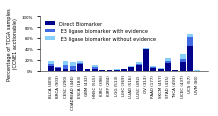

In [43]:
fig,ax = plt.subplots(figsize=(3,1))
labelsp = list(d_tumor_counts.keys())
labels = []
for label in labelsp:
    if label[0]=="CCNE1" and label[1] == "FBXW7":
            labels.append(label)
order = sorted(labels,key =lambda x: x[2])
class1 = [len(d_tumor_counts[x][0]) / d_samples[x[2]] for x in order]
class2 = [len(d_tumor_counts[x][1]) / d_samples[x[2]] for x in order]
class3 = [len(d_tumor_counts[x][2]) / d_samples[x[2]] for x in order]
total = [class1[i] + class2[i] + class3[i] for i in range(len(order))]
lw = [ 3 if "-GLOBAL" in x[0] else 0 for  x in order]
ax.bar(bottom=[0],height=total,x=range(0,len(class1)),width=0.8,edgecolor="black",color="white",lw=lw,ls="solid")
ax.bar(height=class1,x=range(0,len(class1)),width=0.8,color="#00008B",lw=lw,label="Direct Biomarker")
ax.bar(bottom=class1,height=class2,x=range(0,len(class1)),width=0.8,color="#4169E1",lw=lw,label=" E3 ligase biomarker with evidence")
ax.bar(bottom=[class1[x]+class2[x] for x in range(0,len(class2))],height=class3,x=range(0,len(class1)),width=0.8,color="#87CEFA",label=" E3 ligase biomarker without evidence")
ax.set_xticks(range(0,len(class1)))
order_formatted = []
order_formatted = []
for label in order:
    if "-GLOBAL" in label[2]:
        order_formatted.append(label[2]+" ("+str(d_samples["PAN"])+")")
    else:
        order_formatted.append(label[2]+" ("+str(d_samples[label[2]])+")")
ax.set_xticks(range(0,len(order_formatted)))
l = ax.set_xticklabels(order_formatted,rotation=90,fontsize=4)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels([str(x)+"%" for x in range(0,120,20)],fontsize=4)
ax.set_ylabel("Percentage of TCGA samples \n (CCNE1 acctionable)",fontsize=5)

ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=5,labels=labels,handles=handles)

ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
plt.savefig(path_output_plots+"/Acctionability_TCGA_ccne1.pdf", dpi=800,bbox_inches="tight")

### Perform the aggregated visualization

In [31]:
for tumor in d_tumor_totals.keys():
    d_tumor_counts[("-GLOBAL","",tumor)] = (d_tumor_totals[tumor][0],d_tumor_totals[tumor][1],d_tumor_totals[tumor][2])

In [41]:
order

[('-GLOBAL', '', 'ACC'),
 ('-GLOBAL', '', 'BLCA'),
 ('-GLOBAL', '', 'BRCA'),
 ('-GLOBAL', '', 'CESC'),
 ('-GLOBAL', '', 'CHOL'),
 ('-GLOBAL', '', 'COADREAD'),
 ('-GLOBAL', '', 'DLBC'),
 ('-GLOBAL', '', 'ESCA'),
 ('-GLOBAL', '', 'GBM'),
 ('-GLOBAL', '', 'HNSC'),
 ('-GLOBAL', '', 'KICH'),
 ('-GLOBAL', '', 'KIRC'),
 ('-GLOBAL', '', 'KIRP'),
 ('-GLOBAL', '', 'LGG'),
 ('-GLOBAL', '', 'LIHC'),
 ('-GLOBAL', '', 'LUAD'),
 ('-GLOBAL', '', 'LUSC'),
 ('-GLOBAL', '', 'MESO'),
 ('-GLOBAL', '', 'OV'),
 ('-GLOBAL', '', 'PAAD'),
 ('-GLOBAL', '', 'PCPG'),
 ('-GLOBAL', '', 'PRAD'),
 ('-GLOBAL', '', 'SARC'),
 ('-GLOBAL', '', 'SKCM'),
 ('-GLOBAL', '', 'STAD'),
 ('-GLOBAL', '', 'TGCT'),
 ('-GLOBAL', '', 'THCA'),
 ('-GLOBAL', '', 'THYM'),
 ('-GLOBAL', '', 'UCEC'),
 ('-GLOBAL', '', 'UCS'),
 ('-GLOBAL', '', 'UVM')]

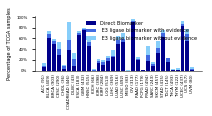

In [42]:
fig,ax = plt.subplots(figsize=(3,1.0))
labelsp = list(d_tumor_counts.keys())

labels = []
for label in labelsp:
    if   "-GLOBAL" in label:
        labels.append(label)
order = sorted(labels,key =lambda x: x[2])
class1 = [len(d_tumor_counts[x][0]) / d_samples[x[2]] for x in order]
class2 = [len(d_tumor_counts[x][1]) / d_samples[x[2]] for x in order]
class3 = [len(d_tumor_counts[x][2]) / d_samples[x[2]] for x in order]
total = [class1[i] + class2[i] + class3[i] for i in range(len(order))]
lw = [ 3 if "-GLOBAL" in x[0] else 0 for  x in order]
ax.bar(bottom=[0],height=total,x=range(0,len(class1)),width=0.8,edgecolor=None,color="white",lw=lw,ls="solid")
ax.bar(height=class1,x=range(0,len(class1)),width=0.8,color="#00008B",lw=lw,label="Direct Biomarker")
ax.bar(bottom=class1,height=class2,x=range(0,len(class1)),width=0.8,color="#4169E1",lw=lw,label=" E3 ligase biomarker with evidence")
ax.bar(bottom=[class1[x]+class2[x] for x in range(0,len(class2))],height=class3,x=range(0,len(class1)),width=0.8,color="#87CEFA",label=" E3 ligase biomarker without evidence")

order_formatted = []
for label in order:
    if "-GLOBAL" in label[2]:
        order_formatted.append(label[2]+" ("+str(d_samples["PAN"])+")")
    else:
        order_formatted.append(label[2]+" ("+str(d_samples[label[2]])+")")

ax.set_xticks(range(0,len(order_formatted)))
l = ax.set_xticklabels(order_formatted,rotation=90,fontsize=4)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels([str(x)+"%" for x in range(0,120,20)],fontsize=4)
ax.set_ylabel("Percentage of TCGA samples",fontsize=5)

ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper right",fontsize=5,labels=labels,handles=handles)

ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
plt.savefig(path_output_plots+"/Acctionability_TCGA.pdf", dpi=800,bbox_inches="tight")

### Numbers

In [25]:
samples_ccne1_ucec=len(df_biomarkers[(df_biomarkers["SAMPLE_ALTERATION"].str.contains("CCNE1"))&(df_biomarkers["TUMOR_MATCH"]==1)&(df_biomarkers["Cancer_Type"]=="UCEC")&(df_biomarkers["EFFECT"]=="Responsive")]["SAMPLE"].unique())
samples_ccne1_ucec

67

In [26]:
samples_ccne1_ucec/d_samples["UCEC"]


0.15331807780320367

In [27]:
x=d_tumor_counts[("-GLOBAL","","COADREAD")]
print (len(x[0]),len(x[1]),len(x[2]))
print (len(x[0])/d_samples["COADREAD"],len(x[1])/d_samples["COADREAD"],len(x[2])/d_samples["COADREAD"])

175 77 150
0.3923766816143498 0.1726457399103139 0.336322869955157


### Save supplementary table 6

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


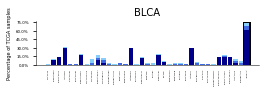

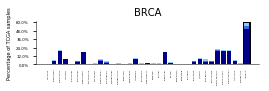

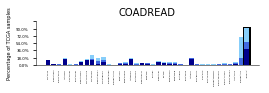

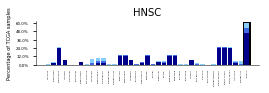

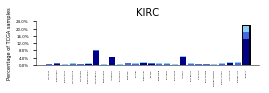

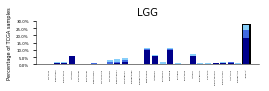

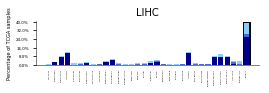

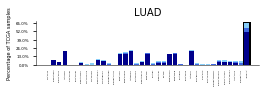

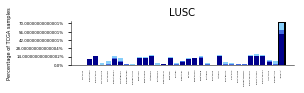

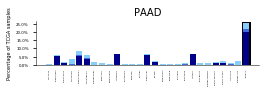

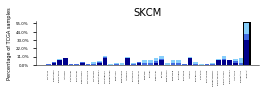

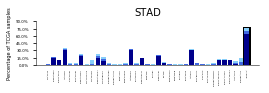

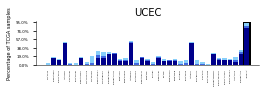

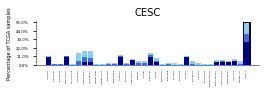

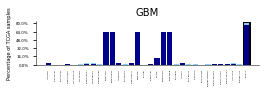

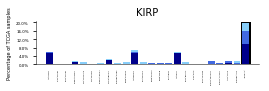

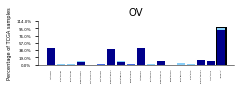

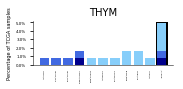

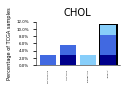

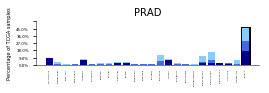

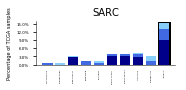

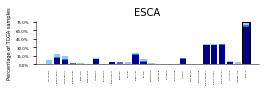

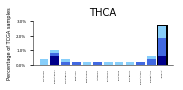

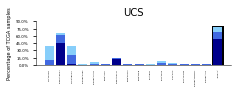

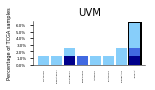

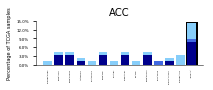

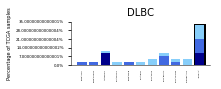

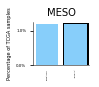

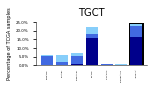

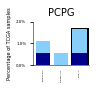

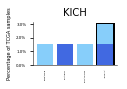

In [28]:
l_data = []
for ttype in d_tumor_totals:
    
    labelsp = list(d_tumor_counts.keys())
    labels = []
    for label in labelsp:
        if label[2] == ttype:
            labels.append(label)
    n = len(labels)
    sizes = np.arange(0.5,4.5,0.5)
    sizes_threshold = np.arange(0,24,3)
    for i in range(0,len(sizes_threshold)):
        if n <= sizes_threshold[i]:
            break
    size = sizes[i]

    
    
    order = sorted(labels,key =lambda x: x[2])
    class1 = [len(d_tumor_counts[x][0]) / d_samples[x[2]] for x in order]
    class2 = [len(d_tumor_counts[x][1]) / d_samples[x[2]] for x in order]
    class3 = [len(d_tumor_counts[x][2]) / d_samples[x[2]] for x in order]
    for x in order:
        l_data.append([ttype,x[0],x[1],len(d_tumor_counts[x][0]),len(d_tumor_counts[x][1]),len(d_tumor_counts[x][2]),d_samples[x[2]]])
    total = [class1[i] + class2[i] + class3[i] for i in range(len(order))]
    maxv = round(np.nanmax(total),2)
    
    
    fig,ax = plt.subplots(figsize=(size,0.8))
    
    
    lw = [ 3 if "-GLOBAL" in x[0] else 0 for  x in order]
    ax.bar(bottom=[0],height=total,x=range(0,len(class1)),width=0.8,edgecolor="black",color="white",lw=lw,ls="solid")
    ax.bar(height=class1,x=range(0,len(class1)),width=0.8,color="#00008B",lw=lw,label="Direct Biomarker")
    ax.bar(bottom=class1,height=class2,x=range(0,len(class1)),width=0.8,color="#4169E1",lw=lw,label=" E3 ligase biomarker with evidence")
    ax.bar(bottom=[class1[x]+class2[x] for x in range(0,len(class2))],height=class3,x=range(0,len(class1)),width=0.8,color="#87CEFA",label=" E3 ligase biomarker without evidence")
    ax.set_xticks(range(0,len(class1)))
    order_formatted = []
    for label in order:
        if "-GLOBAL" in label:
            order_formatted.append(label[0]+";"+label[1])
        else:
            order_formatted.append(label[0]+";"+label[1])
    ax.set_xticks(range(0,len(order_formatted)))
    l = ax.set_xticklabels(order_formatted,rotation=90,fontsize=4)
    step = round(maxv/5,2)
    if step == 0.0:
        step = 0.01
    ax.set_yticks(np.arange(0,maxv+step,step))
    ax.set_yticklabels([str(x)+"%" for x in np.arange(0,maxv*100+step*100,step*100)],fontsize=4)
    ax.set_ylabel("Percentage of TCGA samples",fontsize=5)

    ax.spines['top'].set_linewidth(0.0)
    ax.spines['right'].set_linewidth(0.0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="best",fontsize=5,labels=labels,handles=handles)
    ax.set_title(ttype,fontsize=10)
    ax.tick_params(axis = 'x', labelsize =2  , pad=0.02 ,width=0.0)
    
    plt.savefig(path_output_plots+"/supplementary_plots/Acctionability_TCGA_"+ttype+".pdf", dpi=800,bbox_inches="tight")
df_info_actionability = pd.DataFrame(l_data,columns=["Cancer_Type","Hugo_Symbol","E3_ligase","Direct_Biomarker","E3 ligase biomarker with evidence","E3 ligase biomarker without evidence","Total_Samples"])

In [29]:
df_info_actionability.to_csv(path_output_table,sep="\t",index=False)